In [2]:
import numpy as np
%load_ext autoreload
%autoreload 2

import torch
import sys

sys.path.append('..')

from algorithms.sequence_models.config import TrainConfig

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is ", device)

device is  cuda


In [3]:
from minigrid.wrappers import ImgObsWrapper
from algorithms.sequence_models.decision_S4.dts4 import DecisionS4
from data.door_key_dataset import DoorKeyDataset
from comparison_experiment import AutomatedComparisonExperiment
import gymnasium as gym


inner_env = gym.make('MiniGrid-DoorKey-5x5-v0')
inner_env_human = gym.make('MiniGrid-DoorKey-5x5-v0', render_mode='human')
env = ImgObsWrapper(inner_env)
env_human = ImgObsWrapper(inner_env_human)


max_eval_ep_len = env.max_steps # todo change for other envs
context_len = max_eval_ep_len + 2  # todo change for other envs (DECREASE TO IMPROVE SPEED)

config = TrainConfig(max_eval_ep_len=max_eval_ep_len, context_len=max_eval_ep_len)

n_trajectories = 10_000 # todo is this enough / too much?
experiment_name = f"experiment_door_key_dataset_size={n_trajectories}"
if DoorKeyDataset.exists(experiment_name):
    traj_dataset = DoorKeyDataset.load(experiment_name)
else:
    reward_scale = 1 # todo change for other envs
    traj_dataset = DoorKeyDataset(env, n_trajectories=n_trajectories, reward_scale=reward_scale, prob_keeping_nonzero=0.01)
    traj_dataset.save(experiment_name)

comparison_experiment = AutomatedComparisonExperiment(
    env=env,
    traj_dataset=traj_dataset,
    config=config,
    device=device,
    rtgs_for_train_eval=[0.3, 0.5, 0.7, 1], # todo change for other envs
    rtgs_final_test=np.linspace(0, 1.1, 10, endpoint=True), # todo change for other envs
    env_name=f"MiniGrid-DoorKey-5x5-v0", # todo change for other envs
    experiment_name="automated_comparison"
)

/home/shayan/projects/RL-credit-assignment-experiment/algorithms/sequence_models/decision_S4/s4.py:155: DeprecationWarning: invalid escape sequence '\s'
  """
/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/site-packages/lightning_fabric/plugins/environments/xla.py:18: DeprecationWarning: `ModuleAvailableCache` is a special case of `RequirementCache`. Please use `RequirementCache(module=...)` instead.
  from lightning_fabric.accelerators.tpu import _XLA_AVAILABLE, TPUAccelerator
/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/site-packages/lightning_fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/shayan/miniconda3/envs/rl-explore/lib/

number of parameters 630811
number of parameters 1159579


distribution of rewards in the dataset
training started


  0%|          | 0/200 [00:00<?, ?it/s]

time elapsed: 0:00:05
num of updates: 100
loss: 0.32132
lr 0.00001
grad_norm 0.19317
time elapsed: 0:00:10
num of updates: 200
loss: 0.22560
lr 0.00002
grad_norm 0.09414
time elapsed: 0:00:14
num of updates: 300
loss: 0.14831
lr 0.00003
grad_norm 0.02808
time elapsed: 0:00:19
num of updates: 400
loss: 0.12943
lr 0.00004
grad_norm 0.02066
time elapsed: 0:00:24
num of updates: 500
loss: 0.12514
lr 0.00005
grad_norm 0.01875
time elapsed: 0:00:28
num of updates: 600
loss: 0.12221
lr 0.00006
grad_norm 0.01726
time elapsed: 0:00:33
num of updates: 700
loss: 0.11982
lr 0.00007
grad_norm 0.01818
time elapsed: 0:00:37
num of updates: 800
loss: 0.11727
lr 0.00008
grad_norm 0.01389
time elapsed: 0:00:42
num of updates: 900
loss: 0.11355
lr 0.00009
grad_norm 0.01033
time elapsed: 0:00:47
num of updates: 1000
loss: 0.10724
lr 0.00010
grad_norm 0.00985
time elapsed: 0:00:51
num of updates: 1100
loss: 0.09786
lr 0.00011
grad_norm 0.01170
time elapsed: 0:00:56
num of updates: 1200
loss: 0.08581
lr 0.0

KeyboardInterrupt: 

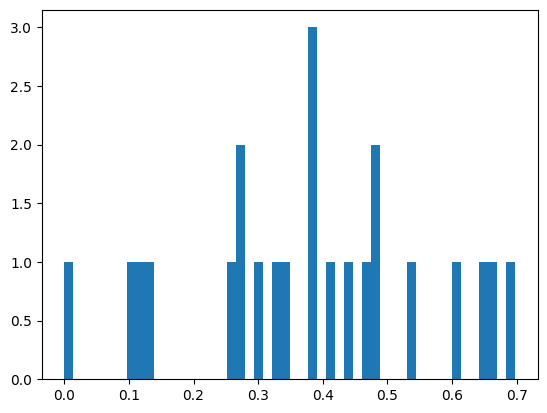

<Figure size 640x480 with 0 Axes>

In [5]:
comparison_experiment.run_and_report(comparison_experiment.s4_experiment, 200)

In [ ]:
comparison_experiment.run_and_report(comparison_experiment.dt_experiment, 200)

In [4]:
# see and record
from algorithms.evaluate_policy import evaluate_policy

policy = comparison_experiment.make_dt_policy(rtg=1)
evaluate_policy(policy, env_human, num_eval_ep=1)

{'eval/avg_reward': 0.0, 'eval/avg_ep_len': 250.0}

In [ ]:
# see and record
from algorithms.evaluate_policy import evaluate_policy

policy = comparison_experiment.make_s4_policy(rtg=1)
evaluate_policy(policy, env_human, num_eval_ep=1)